In [159]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfRegressaoDias.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

split = int(0.7 * len(df))

train = df[0:split] 
test = df[split:]

,CasosDia
Data,
2020-03-15,3
2020-03-16,3
2020-03-17,3
2020-03-18,1
2020-03-19,0
...,...
2023-09-24,0
2023-09-25,13
2023-09-26,14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293 entries, 2020-03-15 to 2023-09-28
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CasosDia  1293 non-null   int64
dtypes: int64(1)
memory usage: 20.2 KB


# Média Móvel

<Axes: xlabel='Data'>

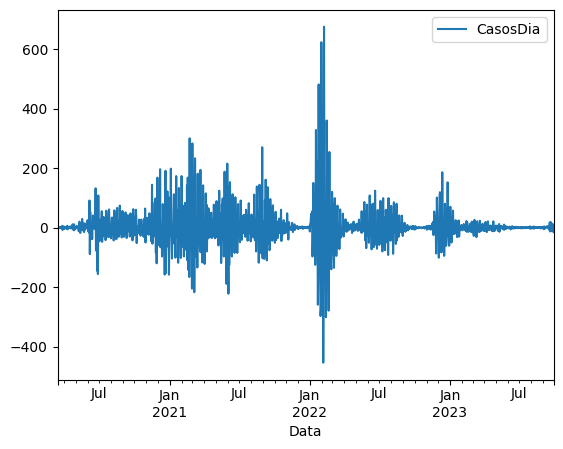

In [160]:
df.diff().plot() 



!! ULTIMO VALOR (20) É A MÉDIA !!!


,PARA,MAE,MSE,RMSE
0,3,19.29,1608.27,40.1
1,3,19.29,1608.27,40.1
2,3,19.29,1608.27,40.1
3,3,19.29,1608.27,40.1
4,3,19.29,1608.27,40.1
5,3,19.29,1608.27,40.1
6,3,19.29,1608.27,40.1
7,3,19.29,1608.27,40.1
8,3,19.29,1608.27,40.1
9,3,19.29,1608.27,40.1


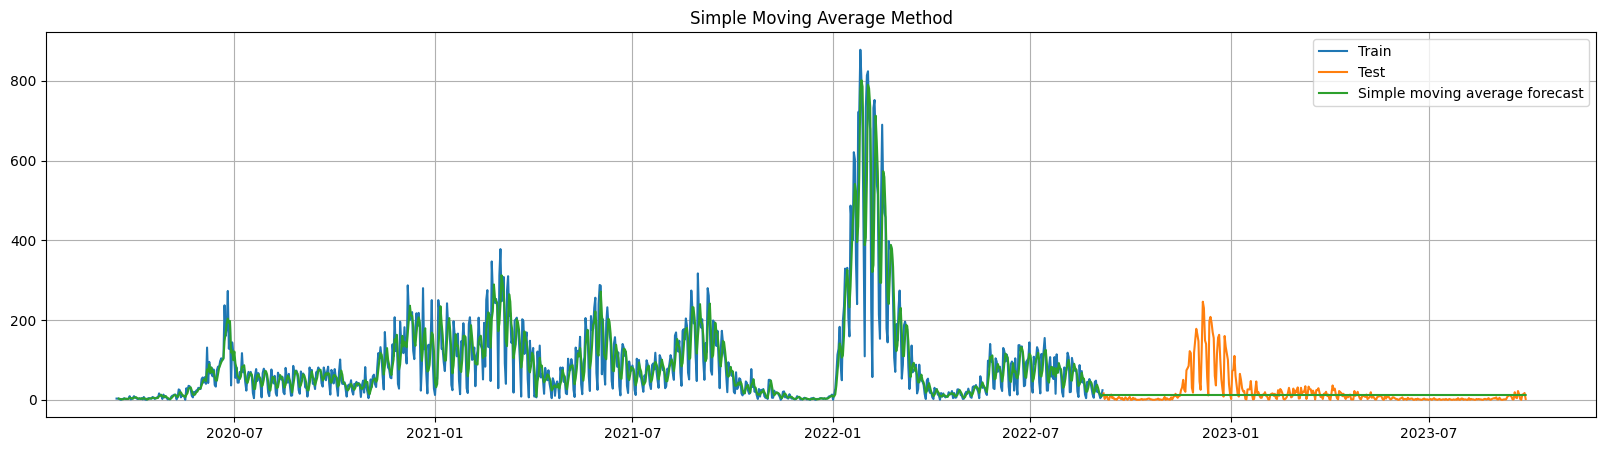

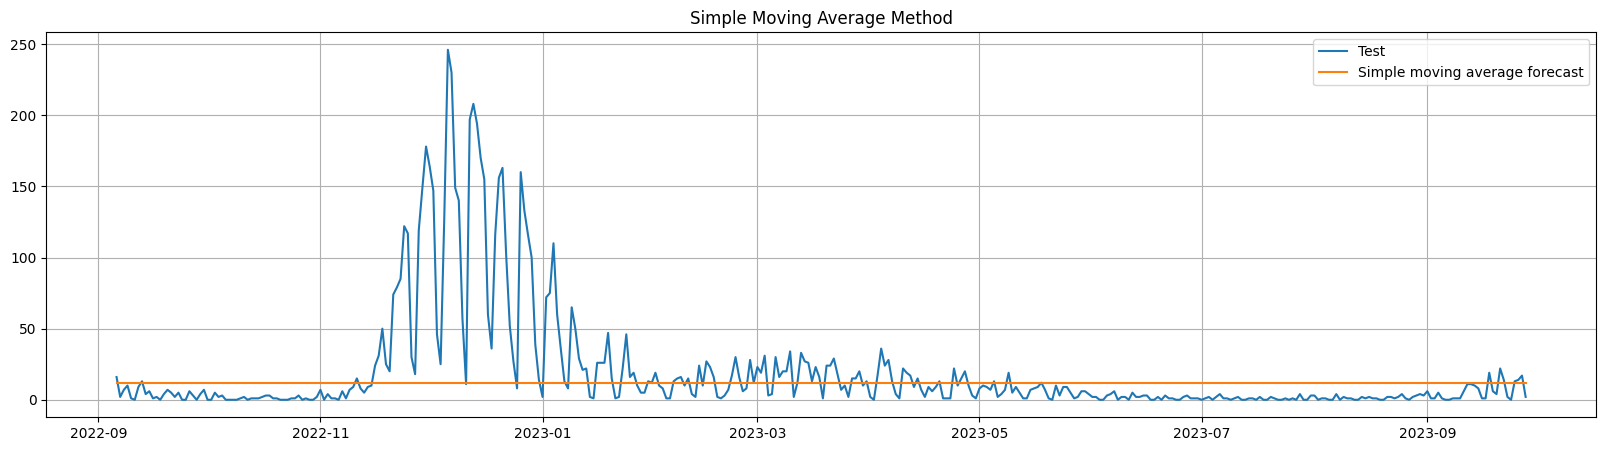

In [161]:
janela = range(1, 20)

mseMM = []
rmseMM = []
maeMM = []
parametrosMM = []
auxMae = 0


for j in range(20):

    maeCalibra = 0
    auxMae = 0
    ## CALIBRAR
    for i in janela:
        media_movel = df['CasosDia'].rolling(i).mean()
        media_movel[split:] = media_movel[split-1]

        maeCalibra = mean_absolute_error(test['CasosDia'], media_movel[split:]).round(2)

        if (maeCalibra < auxMae or auxMae == 0):
            auxMae = maeCalibra
            para_MM = i



    ## TREINA
    media_movel = df['CasosDia'].rolling(para_MM).mean()
    media_movel[split:] = media_movel[split-1]

    mae = mean_absolute_error(test['CasosDia'], media_movel[split:]).round(2)
    mse = mean_squared_error(test['CasosDia'], media_movel[split:]).round(2)
    rmse = np.sqrt(mse).round(2)

    mseMM.append(mse)
    rmseMM.append(rmse)
    maeMM.append(mae)
    parametrosMM.append(para_MM)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoMM = max(set(parametrosMM), key=parametrosMM.count)
media_maeMM = np.mean(maeMM)
media_mseMM = np.mean(mseMM)
media_rmseMM = np.mean(rmseMM)

parametrosMM.append(parametroMaisEscolhidoMM)
maeMM.append(media_maeMM)
mseMM.append(media_mseMM)
rmseMM.append(media_rmseMM)


dfMediaMovel = pd.DataFrame({
    'PARA': parametrosMM,
    'MAE': maeMM,
    'MSE': mseMM,
    'RMSE': rmseMM
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfMediaMovel)



plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['CasosDia'], label='Train')
plt.plot(test['CasosDia'], label='Test')
plt.plot(media_movel, label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(test['CasosDia'], label='Test')
plt.plot(media_movel[split:], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()


# SUAVIZAÇÃO EXPONENCIAL - exponential-smoothing

In [162]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9]

df = pd.read_csv("planilhas/dfRegressaoDias.csv", sep=';', index_col="Data")

X_treino = df[:split].index.values
X_teste = df[split:].index.values

Y_treino = df[split:].values
Y_teste = df[split:].values

#print((X_treino))
#print((Y_treino))
#print(len(X_treino))
#print(len(Y_treino))

fit_alpha_02 = ExponentialSmoothing(X_treino).fit(smoothing_level=0.2)
fit_alpha_02 = fit_alpha_02.forecast(len(X_teste))




NameError: name 'ExponentialSmoothing' is not defined